In [42]:
import torch
import os
import sys
import matplotlib
from matplotlib import pyplot as plt

sys.path.insert(1, "C:\\Users\\Maxim\\Documents\\GitHub\\Studium\\Bachelor\\schnetpack\\src")

import schnetpack as spk
import schnetpack.transform as trn

import numpy as np
import math
import tqdm

from ase.io.extxyz import read_xyz

In [43]:
model = torch.load("./jonas_hessian_500_loose")

with open("./found_conformers_run0.xyz", "r") as f:
    base_configuration = list(read_xyz(f, index = 0))[0]

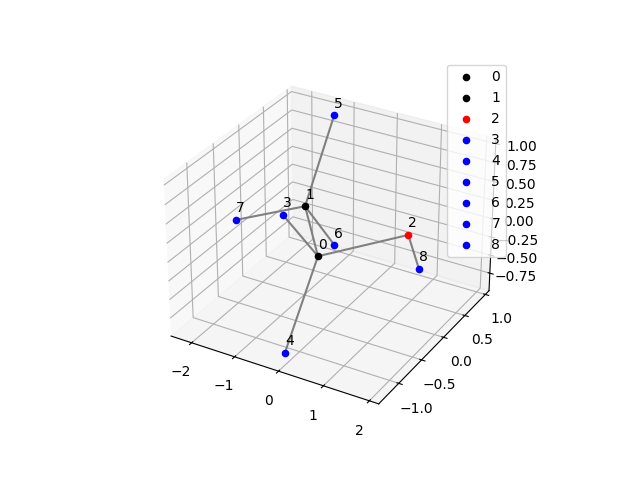

In [44]:
%matplotlib widget

def plot_positions(atom):
    positions = atom.positions
    numbers = atom.numbers
    
    colors = {6: "black", 8: "red", 1: "blue"}
    colors = [colors[n] for n in numbers]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i, (x, y, z) in enumerate(positions):
        ax.scatter(x, y, z, c=colors[i], label=i)
        ax.text(x, y, z + 0.1, f"{i}", color='black')  # Shift the label slightly above the point
    
    # draw the bond between atom (0, 2) and (2, 8)
    for i, j in [(0, 2), (2, 8), (0, 1), (0, 3), (0, 4), (1, 7), (1, 5), (1, 6)]:
        x = [positions[i][0], positions[j][0]]
        y = [positions[i][1], positions[j][1]]
        z = [positions[i][2], positions[j][2]]
        ax.plot(x, y, z, c="gray")
    
    plt.legend()
    plt.show()

plot_positions(base_configuration)


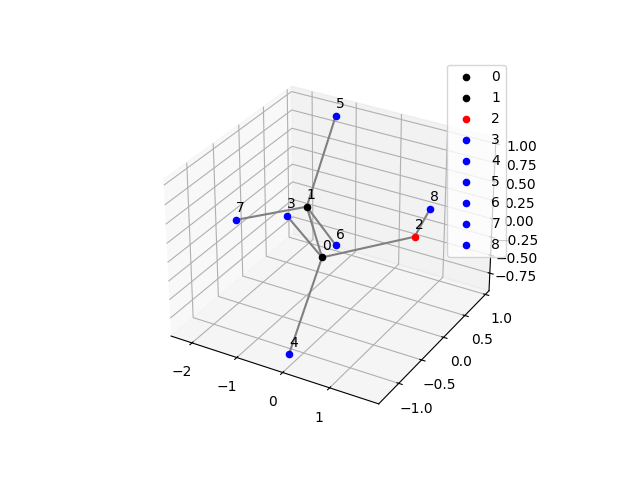

In [57]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    
# rotate the connection between atom 0 and 2 (C-O bond)
# atom 8 the H atom is connected to atom 2 (O)
def rotate_C_O(atom, angle):
    # origin vector is the C-O bond
    origin = atom.positions[2] - atom.positions[0]
    # rotate the H atom around the C-O bond
    positions = atom.positions
    
    matrix = rotation_matrix(origin, math.radians(angle))
    new_H_position = np.dot(matrix, positions[8] - positions[2]) + positions[2]
    
    new_atom = atom.copy()
    new_atom.positions[8] = new_H_position
    
    return new_atom

def rotate_C_C(atom, angle):
    # origin vector is the C-C bond (atom 0 and 1)
    origin = atom.positions[1] - atom.positions[0]

    # rotate the H atoms (5, 6, 7) around the C-C bond
    positions = atom.positions
    
    matrix = rotation_matrix(origin, math.radians(angle))
    new_H5_position = np.dot(matrix, positions[5] - positions[1]) + positions[1]
    new_H6_position = np.dot(matrix, positions[6] - positions[1]) + positions[1]
    new_H7_position = np.dot(matrix, positions[7] - positions[1]) + positions[1]
    
    new_atom = atom.copy()
    new_atom.positions[5] = new_H5_position
    new_atom.positions[6] = new_H6_position
    new_atom.positions[7] = new_H7_position
    
    return new_atom
    

new_atom_1 = rotate_C_O(base_configuration, -45)
new_atom_2 = rotate_C_C(base_configuration, 60)

plot_positions(new_atom_1)
# plot_positions(new_atom_2)

In [46]:
converter = spk.interfaces.AtomsConverter(
    neighbor_list=trn.ASENeighborList(cutoff=5.0), dtype=torch.float32, device="cuda"
)

def get_energy(atom):
    inputs = converter(atom)
    out = model(inputs)
    return out["energy"].item()

energy = get_energy(base_configuration)
print(f"Energy of base configuration: {energy}")

Energy of base configuration: -97089.78994492952


In [61]:
# Calculate potential energy surface
angles = np.linspace(-180, 180, 100)
energies = []

for angle1 in tqdm.tqdm(angles):
    for angle2 in angles:
        atom = rotate_C_O(base_configuration, angle1)
        atom = rotate_C_C(atom, angle2)
        energy = get_energy(atom)
        energies.append((angle1, angle2, energy))



100%|██████████| 100/100 [1:54:24<00:00, 68.65s/it]


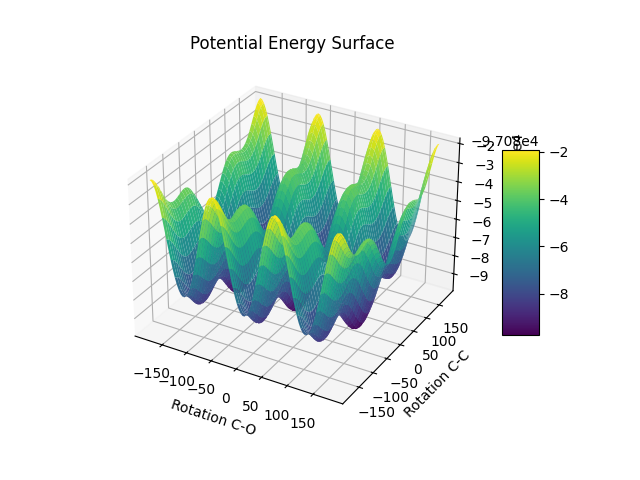

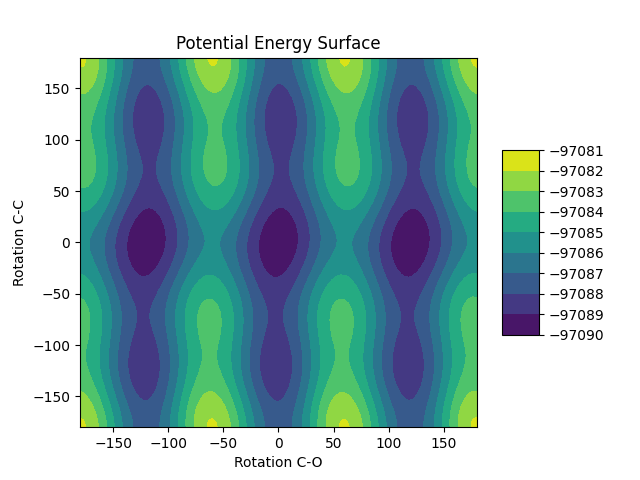

In [64]:
def plot_PES_3d(energies):
    x = np.array([p[0] for p in energies])
    y = np.array([p[1] for p in energies])
    z = np.array([p[2] for p in energies])

    # Create grid data for X and Y, using unique values
    x_unique = np.unique(x)
    y_unique = np.unique(y)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Reshape Z data into the same shape as X and Y
    Z = np.array(z).reshape(len(x_unique), len(y_unique))

    # Create the figure and 3D axes
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # Add color bar to show the range of Z values
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Labels and title
    ax.set_xlabel('Rotation C-O')
    ax.set_ylabel('Rotation C-C')
    ax.set_zlabel('Energy')
    ax.set_title('Potential Energy Surface')

    # Show the plot
    plt.show()
    
def plot_PES_contour(energies):
    x = np.array([p[0] for p in energies])
    y = np.array([p[1] for p in energies])
    z = np.array([p[2] for p in energies])

    # Create grid data for X and Y, using unique values
    x_unique = np.unique(x)
    y_unique = np.unique(y)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Reshape Z data into the same shape as X and Y
    Z = np.array(z).reshape(len(x_unique), len(y_unique))

    # Create the figure and 3D axes
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot the surface
    surf = ax.contourf(X, Y, Z, cmap='viridis')

    # Add color bar to show the range of Z values
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Labels and title
    ax.set_xlabel('Rotation C-O')
    ax.set_ylabel('Rotation C-C')
    ax.set_title('Potential Energy Surface')

    # Show the plot
    plt.show()
    
plot_PES_3d(energies)
plot_PES_contour(energies)


In [10]:
print("End")

End
